In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error

from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.tseries.offsets import DateOffset

In [2]:
#functions:

def i_n(series):
    i = 0
    dftest = adfuller(np.diff(series,i), autolag='AIC')
    test_stat = dftest[0]
    critical_val_5 = dftest[4]['5%']
    while test_stat > critical_val_5:
        i+=1
        dftest = adfuller(np.diff(series,i), autolag='AIC')
        test_stat = dftest[0]
        critical_val_5 = dftest[4]['5%']
    return(i)

# Plant 1 gen & weather data

In [3]:
p1_gen = pd.read_csv('../../data/p1_gen_dtindex.csv', index_col=0, parse_dates=True)
p1_gen.head()

,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,,
2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [9]:
# let's go ahead and import the temp sensor

p1_wthr = pd.read_csv('../../data/Plant_1_Weather_Sensor_Data.csv', index_col=0, parse_dates=True)
p1_wthr.head()

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


---

# 5 days + sensor data

- forecasting daily yield
- 6/13 onwards
- 4 days train
- 1 day test
- 2 day forward forecast

In [5]:
# gen data

pred_6_13 = p1_gen.copy()
pred_6_13 = pred_6_13[pred_6_13.index >= '2020-06-13 00:00:00'][['DAILY_YIELD']]
pred_6_13 = pred_6_13.groupby('DATE_TIME').sum()
pred_6_13

,DAILY_YIELD
DATE_TIME,
2020-06-13 00:00:00,5683.214286
2020-06-13 00:15:00,0.000000
2020-06-13 00:30:00,0.000000
2020-06-13 00:45:00,0.000000
2020-06-13 01:00:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


In [12]:
# wthr data

pred_wthr = p1_wthr.copy()
pred_wthr = pred_wthr[pred_wthr.index >= '2020-06-13 00:00:00']
pred_wthr

# looks like there are 2 extra rows here, compared to the gen data
# checking rows per day

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-06-13 00:00:00,4135001,HmiyD2TTLFNqkNe,21.771613,19.357530,0.0
2020-06-13 00:15:00,4135001,HmiyD2TTLFNqkNe,21.730046,19.504081,0.0
2020-06-13 00:30:00,4135001,HmiyD2TTLFNqkNe,21.687068,19.562803,0.0
2020-06-13 00:45:00,4135001,HmiyD2TTLFNqkNe,21.619232,19.559182,0.0
2020-06-13 01:00:00,4135001,HmiyD2TTLFNqkNe,21.625968,19.787058,0.0
...,...,...,...,...,...
2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0


### CHECKING DISCREPANCIES IN ROW COUNT IN GEN/WTHR DATA

In [17]:
# rows per day for both gen and wthr

print(len(pred_6_13[pred_6_13.index.day == 13]) ,len(pred_wthr[pred_wthr.index.day == 13]))
print(len(pred_6_13[pred_6_13.index.day == 14]) ,len(pred_wthr[pred_wthr.index.day == 14]))
print(len(pred_6_13[pred_6_13.index.day == 15]) ,len(pred_wthr[pred_wthr.index.day == 15]))
print(len(pred_6_13[pred_6_13.index.day == 16]) ,len(pred_wthr[pred_wthr.index.day == 16]))
print(len(pred_6_13[pred_6_13.index.day == 17]) ,len(pred_wthr[pred_wthr.index.day == 17]))

# day 17 gen data is 2 rows short

96 96
96 96
96 96
96 96
94 96


In [18]:
pred_6_13[pred_6_13.index.day == 17]

,DAILY_YIELD
DATE_TIME,
2020-06-17 00:00:00,6955.232143
2020-06-17 00:15:00,0.000000
2020-06-17 00:30:00,0.000000
2020-06-17 00:45:00,0.000000
2020-06-17 01:00:00,0.000000
...,...
2020-06-17 22:45:00,129571.000000
2020-06-17 23:00:00,129571.000000
2020-06-17 23:15:00,129571.000000


In [20]:
pred_wthr[pred_wthr.index.day == 17]

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-06-17 00:00:00,4135001,HmiyD2TTLFNqkNe,22.895672,21.465773,0.0
2020-06-17 00:15:00,4135001,HmiyD2TTLFNqkNe,22.868416,21.381974,0.0
2020-06-17 00:30:00,4135001,HmiyD2TTLFNqkNe,22.826764,21.210284,0.0
2020-06-17 00:45:00,4135001,HmiyD2TTLFNqkNe,22.795615,21.357155,0.0
2020-06-17 01:00:00,4135001,HmiyD2TTLFNqkNe,22.771452,21.472048,0.0
...,...,...,...,...,...
2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0


In [27]:
# rows in wthr data, that aren't in gen data, from 6/17

df_missing_rows = pd.merge(pred_wthr, pred_6_13, left_index=True, right_index=True, how='outer', suffixes=('','_y'), indicator=True)
rows_in_df1_not_in_df2 = df_missing_rows[df_missing_rows['_merge']=='left_only'][pred_wthr.columns]

rows_in_df1_not_in_df2

,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,
2020-06-17 06:15:00,4135001,HmiyD2TTLFNqkNe,22.093398,20.822978,0.019175
2020-06-17 06:30:00,4135001,HmiyD2TTLFNqkNe,22.275627,21.973568,0.034624


In [26]:
# checking gen data for missing indexes

pred_6_13[(pred_6_13.index == '2020-06-17 06:15:00') | (pred_6_13.index == '2020-06-17 06:30:00')]

,DAILY_YIELD
DATE_TIME,


In [28]:
# double checking gen data indexes from 6/17, between 6-7a 

pred_6_13[(pred_6_13.index >= '2020-06-17 06:00:00') & (pred_6_13.index <= '2020-06-17 07:00:00')]

,DAILY_YIELD
DATE_TIME,
2020-06-17 06:00:00,0.000000
2020-06-17 06:45:00,0.500000
2020-06-17 07:00:00,362.660714


### MERGING GEN & WTHR DATA

In [32]:
# so we'll merge on the gen data, using all 3: ambient & module temp, & irradiation

pred_6_13.merge(pred_wthr[['AMBIENT_TEMPERATURE','MODULE_TEMPERATURE', 'IRRADIATION']], 
                left_index=True, right_index=True, )

,DAILY_YIELD,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,
2020-06-13 00:00:00,5683.214286,21.771613,19.357530,0.0
2020-06-13 00:15:00,0.000000,21.730046,19.504081,0.0
2020-06-13 00:30:00,0.000000,21.687068,19.562803,0.0
2020-06-13 00:45:00,0.000000,21.619232,19.559182,0.0
2020-06-13 01:00:00,0.000000,21.625968,19.787058,0.0
...,...,...,...,...
2020-06-17 22:45:00,129571.000000,22.150570,21.480377,0.0
2020-06-17 23:00:00,129571.000000,22.129816,21.389024,0.0
2020-06-17 23:15:00,129571.000000,22.008275,20.709211,0.0


---

# Using 17 days + adding temp sensor 

- 14 days train
- 3 days test
- 3 days forecasted forward

In [28]:
pred_gen_17d = pred_gen_og[(pred_gen_og.index.month == 6) & 
                          (pred_gen_og.index.day >= 1)]
pred_gen_17d = pred_gen_17d.groupby('DATE_TIME').sum()[1:] # greater than 6/1 00:00:00, bc it has prev days daily yield
pred_gen_17d

,PLANT_ID,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
DATE_TIME,,,,,
2020-06-01 00:15:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 00:30:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 00:45:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 01:00:00,90970022,0.0,0.0,0.000000,153519480.0
2020-06-01 01:15:00,90970022,0.0,0.0,0.000000,153519480.0
...,...,...,...,...,...
2020-06-17 22:45:00,90970022,0.0,0.0,129571.000000,156142755.0
2020-06-17 23:00:00,90970022,0.0,0.0,129571.000000,156142755.0
2020-06-17 23:15:00,90970022,0.0,0.0,129571.000000,156142755.0


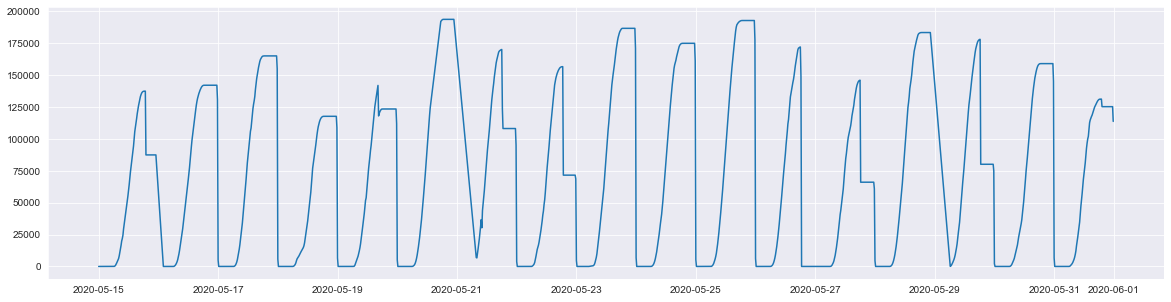

In [19]:
fig, ax = plt.subplots(figsize=(20,5))
plt.plot(pred_gen_may.DAILY_YIELD)
plt.show()